In [1]:
import pandas as pd
from cleaning import create_demand
import pyomo.environ as pyo
import pyomo
import numpy as np
import random

# Data import

In [2]:
nodes = pd.read_pickle("../../data/original/nodes.pkl")
channels = pd.read_pickle("../../data/original/channels.pkl")

In [3]:
channels["base_fee"] = channels.loc[:, "base_fee"].apply(lambda x: random.uniform(0,100)) # if x==0 else x)
channels["rate_fee"] = channels.loc[:, "rate_fee"].apply(lambda x: random.uniform(0.001,0.1)) # if x==0 else x)

## Modeling

In [4]:
pyomo.common.timing.report_timing()

In [5]:
# Multiplication to set the same base unit for all computations
channels["capacity"] = channels["capacity"] * 1000000
channels["base_fee"] = channels["base_fee"] * 1000000

In [6]:
model = pyo.ConcreteModel(name="Min cost flow problem")
model.NODES = pyo.Set(initialize=nodes.index)
model.CHANNELS = pyo.Set(initialize=[(channels.loc[i, "node1_pub"], channels.loc[i, "node2_pub"]) for i in channels.index])

           0 seconds to construct Block ConcreteModel; 1 index total
        0.03 seconds to construct Set NODES; 1 index total
        0.39 seconds to construct Set CHANNELS; 1 index total


In [7]:
transaction_amount = 1000000
nodes = create_demand(nodes, transaction_amount,
                      source="02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3",destination="0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08")

Transaction of 1000000 sats.
Sender: VeniceForever
Receiver: ShatSat412.


In [8]:
model.x = pyo.Var(model.CHANNELS, domain=pyo.NonNegativeIntegers, bounds=(0,1))
model.a = pyo.Var(model.CHANNELS, domain=pyo.NonNegativeReals, bounds=(0, max(nodes["demand"])))

        0.15 seconds to construct Var x; 89898 indices total
        0.14 seconds to construct Var a; 89898 indices total


In [9]:
channels.reset_index(inplace=True)
channels.set_index(["node1_pub", "node2_pub"], inplace=True)
channels.sort_index(inplace=True)

### Objective function

$$
min \sum_{} ^{} amount_i \times feerate_{i} + x_{i} \times basefee_{i} + x_{i} \times \frac{1}{Prob_{i}}
$$

In [10]:
## Uniform distribution
channels["prob"] = np.random.uniform(low=0, high=channels["capacity"])/channels["capacity"]

In [11]:
channels

channel_id  \
node1_pub                                          node2_pub                                                                   
0200000000727d3b67513c916f16975e3bf8f3304cf3fcf... 0360a41eb8c3fe09782ef6c984acbb003b0e1ebc4fe10ae...     914492408312299520   
0200000000a3eff613189ca6c4070c89206ad658e286751... 02e4971e61a3f55718ae31e2eed19aaf2e32caf3eb5ef5f...     858567948297371650   
                                                   02f1a8c87607f415c8f22c00593002775941dea48869ce2...     838135723780210689   
                                                   02f460ae6d3d3e104f8afe520ae0cff3d94c35c2ba8df66...     837978493509959681   
020003b9499a97c8dfbbab6b196319db37ba9c37bccb604... 0205198c099c45acedf988445f71da087ca39cd80847e53...     906034964784021504   
...                                                                                                                      ...   
03ffc95f28306c88f5c033774ac5e59c30f6cc91e76af6c... 02cc79b8d771cc79d323bd71e54ef1780cab50e7c0ef2a4...  INV865354134044606465   
                                                   02f1a8c87607f415c8f22c00593002775941dea48869ce2...  INV865369527244357633   
03ffcd6f3e5880b2ce51de42ab922ec3c224fc47843396d... 0217890e3aad8d35bc054f43acc00084b25229ecff0ab68...  INV770366225064394752   
                                                   028c8c9b0b588d00afabe905799aee0225a9315cdb63d76...  INV770918179822239744   
                                                   02a04446caa81636d60d63b066f2814cbd3a6b5c258e317...  INV770630107742011392   

                                                                                                       rate_fee  \
node1_pub                                          node2_pub                                                      
0200000000727d3b67513c916f16975e3bf8f3304cf3fcf... 0360a41eb8c3fe09782ef6c984acbb003b0e1ebc4fe10ae...  0.042266   
0200000000a3eff613189ca6c4070c89206ad658e286751... 02e4971e61a3f55718ae31e2eed19aaf2e32caf3eb5ef5f...  0.052581   
                                                   02f1a8c87607f415c8f22c00593002775941dea48869ce2...  0.041422   
                                                   02f460ae6d3d3e104f8afe520ae0cff3d94c35c2ba8df66...  0.051075   
020003b9499a97c8dfbbab6b196319db37ba9c37bccb604... 0205198c099c45acedf988445f71da087ca39cd80847e53...  0.085725   
...                                                                                                         ...   
03ffc95f28306c88f5c033774ac5e59c30f6cc91e76af6c... 02cc79b8d771cc79d323bd71e54ef1780cab50e7c0ef2a4...  0.095116   
                                                   02f1a8c87607f415c8f22c00593002775941dea48869ce2...  0.047020   
03ffcd6f3e5880b2ce51de42ab922ec3c224fc47843396d... 0217890e3aad8d35bc054f43acc00084b25229ecff0ab68...  0.010804   
                                                   028c8c9b0b588d00afabe905799aee0225a9315cdb63d76...  0.090326   
                                                   02a04446caa81636d60d63b066f2814cbd3a6b5c258e317...  0.039696   

                                                                                                           base_fee  \
node1_pub                                          node2_pub                                                          
0200000000727d3b67513c916f16975e3bf8f3304cf3fcf... 0360a41eb8c3fe09782ef6c984acbb003b0e1ebc4fe10ae...  8.148249e+07   
0200000000a3eff613189ca6c4070c89206ad658e286751... 02e4971e61a3f55718ae31e2eed19aaf2e32caf3eb5ef5f...  8.351388e+07   
                                                   02f1a8c87607f415c8f22c00593002775941dea48869ce2...  4.201910e+07   
                                                   02f460ae6d3d3e104f8afe520ae0cff3d94c35c2ba8df66...  1.306398e+06   
020003b9499a97c8dfbbab6b196319db37ba9c37bccb604... 0205198c099c45acedf988445f71da087ca39cd80847e53...  6.489835e+07   
...                                                                                                             ...   
0

In [12]:
#def objective_function(model: pyo.ConcreteModel):
#    return sum(model.a[i] * channels.loc[i, "rate_fee"] for i in model.CHANNELS) + sum(model.x[i] * channels.loc[i, "base_fee"] for i in model.CHANNELS)

def objective_function(model: pyo.ConcreteModel):
    return sum(model.a[i] * channels.loc[i, "rate_fee"] + model.x[i] * channels.loc[i, "base_fee"] + model.x[i] * (1/channels.loc[i, "prob"]) for i in model.CHANNELS)

model.totalCost = pyo.Objective(rule=objective_function(model), sense=pyo.minimize)

           0 seconds to construct Objective totalCost; 1 index total


### Constraints


#### Capacity constraint

$$amount_{i,j} \le capacity_{i,j} \times x_{i,j} \text{ } \forall (i,j) \in E$$

In [13]:
def capacity_constraint(model: pyo.ConcreteModel, a, b):
    return model.a[(a, b)] <= channels.loc[(a, b), "capacity"] * model.x[(a, b)]

model.CapacityConstraint = pyo.Constraint(model.CHANNELS, rule=capacity_constraint, name="Capacity constraint")

        6.06 seconds to construct Constraint CapacityConstraint; 89898 indices total


#### Flow balance constraint

$$\sum_{(s,i) \in E} amount_{s,i} - \sum_{(i,t) \in E} amount_{i,d} = b_i \text{ } \forall i \in V$$

where $s$ is the source node, $d$ is the destination node, $i$ is every intermediary node


In [14]:
channels.reset_index(inplace=True)
channels.set_index("channel_id", inplace=True)

def flow_balance_constraint(model: pyo.ConcreteModel, n: str):
    InFlow = sum(model.a[(channels.loc[a, "node1_pub"], channels.loc[a, "node2_pub"])] for a in nodes.loc[n, 'incoming_channels'])
    OutFlow = sum(model.a[(channels.loc[a, "node1_pub"], channels.loc[a, "node2_pub"])] for a in nodes.loc[n, 'outgoing_channels'])
    return  OutFlow + nodes.loc[n, "demand"] == InFlow

model.FlowBalanceConstraint = pyo.Constraint(model.NODES, rule=flow_balance_constraint, name="Flow balance constrain")

channels.reset_index(inplace=True)
channels.set_index(["node1_pub", "node2_pub"], inplace=True)
channels.sort_index(inplace=True) 

        3.58 seconds to construct Constraint FlowBalanceConstraint; 11984 indices total


## Solving the model

In [15]:
#from pyomo.common.tempfiles import TempfileManager
#TempfileManager.tempdir = "/home/filippo/repositories/LN-pathfinding"

In [16]:
opt = pyo.SolverFactory('cbc')
#opt = pyo.SolverFactory('cplex_direct')
results = opt.solve(model, tee=True, keepfiles=True)

if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    print('\nOptimal solution found')
elif results.solver.termination_condition == pyo.TerminationCondition.feasible:
    print('\nFeasible but not proven optimal solution found')
elif results.solver.termination_condition == pyo.TerminationCondition.infeasible:
    raise Exception("The model is infeasible")
else:
    print('\nSolver Status: ',  results.solver.status)
    raise Exception(results.solver.status)

print('\nObject function value = ', model.Objective())


           0 seconds to construct Var ONE_VAR_CONSTANT; 1 index total
      [    1.97] Generated LP representation
Solver log file: '/tmp/tmpk9er7iv3.cbc.log'
Solver solution file: '/tmp/tmpv8wihavj.pyomo.soln'
Solver problem files: ('/tmp/tmpv8wihavj.pyomo.lp',)
Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  9 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpv8wihavj.pyomo.lp -stat=1 -solve -solu /tmp/tmpv8wihavj.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 95884 (-5998) rows, 173818 (-5978) columns and 335144 (-23898) elements
Statistics for presolved model
Original problem has 89898 integers (89898 of which binary)
Presolved problem has 89898 integers (89898 of which binary)
==== 0 zero objective 173818 different
==== absolute objective values 173818 different
==== for integers 0 zero objective 89898 different
==== for integers absolute objective values 89898 different
===== end objective cou

In [17]:
#from pyomo.opt import SolverStatus, TerminationCondition

print("Solver Status: ",  results.solver[0]["System time"])


Solver Status:  70.17


In [18]:
from decimal import Decimal
pd.set_option('display.max_colwidth', 10000000000000000000000000000000000000000000000000000)
DF_channels = pd.DataFrame()
c = 0
for index, value in model.a.extract_values().items():
    if value > 0.1:
        DF_channels.loc[c, "source"] = index[0]
        DF_channels.loc[c, "destination"] = index[1]
        try:
            DF_channels.loc[c, "source-alias"] = nodes.loc[index[0], "alias"]
        except KeyError:
            print("Source alias not found in nodes database: placeholder inserted")
            DF_channels.loc[c, "source-alias"] = "source-alias"
            pass
        try:
            DF_channels.loc[c, "destination-alias"] = nodes.loc[index[1], "alias"]
        except KeyError:
            print("Destination alias not found in nodes database: placeholder inserted")
            DF_channels.loc[c, "destination-alias"] = "destination-alias"
            pass
        DF_channels.loc[c, "capacity"] = Decimal(channels.loc[index, "capacity"]/1000000)
        DF_channels.loc[c, "amount"] = Decimal(value/1000000)
        DF_channels.loc[c, "base_fee"] = Decimal(channels.loc[(index[0], index[1]), "base_fee"]/1000000)
        DF_channels.loc[c, "rate_fee"] = channels.loc[(index[0], index[1]), "rate_fee"]
        #DF_channels.loc[c, "used_fl"] = channels.loc[]
        c += 1

DF_channels_pos = DF_channels[DF_channels["amount"]!=0]

In [19]:
DF_channels[DF_channels["amount"]> DF_channels["capacity"]]

,source,destination,source-alias,destination-alias,capacity,amount,base_fee,rate_fee


In [20]:
DF_fixed = pd.DataFrame()
c = 0
for index, value in model.x.extract_values().items():
    if value != 0:
        DF_fixed.loc[c, "source"] = index[0]
        DF_fixed.loc[c, "destination"] = index[1]
        DF_fixed.loc[c, "used"] = Decimal(value)
        c += 1

DF_fixed_pos = DF_fixed[DF_fixed["used"]!=0]
DF_fixed_pos

,source,destination,used
0,02103f1826be6287c8430e653de06ef16d94b3106c01937a78f5ae2c89bd40f234,03c5bfa5cab7e52e7cebc45fd1b86ea30ad518648651314563452b78b822333660,1
1,023619ad26f17792d0c217202587651af088ecb637a3fd3e54b42c4b5f71947318,02ba54585837609251865ba9835a32fbeb07f96abc20767dedaafeb17a2e5b8acf,1
2,026f46207fd290a33cbd86e29b3ad0a47cdd44ab9aa5267cde66483e10aa9d3180,03e7d1b2db2f6909365a066a2b40d5ef3a66f1c4d70d8cac3337e09ff2fd2d408f,1
3,02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3,023619ad26f17792d0c217202587651af088ecb637a3fd3e54b42c4b5f71947318,1
4,02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3,026f46207fd290a33cbd86e29b3ad0a47cdd44ab9aa5267cde66483e10aa9d3180,1
5,02ba54585837609251865ba9835a32fbeb07f96abc20767dedaafeb17a2e5b8acf,0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08,1
6,030c3f19d742ca294a55c00376b3b355c3c90d61c6b6b39554dbc7ac19b141c14f,02103f1826be6287c8430e653de06ef16d94b3106c01937a78f5ae2c89bd40f234,1
7,0357853bbdbeda5b662783f391f29bd10194e2254d0f091eb4116a0b405001dd52,030c3f19d742ca294a55c00376b3b355c3c90d61c6b6b39554dbc7ac19b141c14f,1
8,037659a0ac8eb3b8d0a720114efc861d3a940382dcfa1403746b4f8f6b2e8810ba,0357853bbdbeda5b662783f391f29bd10194e2254d0f091eb4116a0b405001dd52,1
9,03c5bfa5cab7e52e7cebc45fd1b86ea30ad518648651314563452b78b822333660,0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08,1


### All data about channels on path

In [21]:
intersection = DF_fixed_pos.merge(DF_channels_pos, on=["source", "destination"], how="outer")
final = intersection[intersection["amount"]>0]
final

,source,destination,used,source-alias,destination-alias,capacity,amount,base_fee,rate_fee
0,02103f1826be6287c8430e653de06ef16d94b3106c01937a78f5ae2c89bd40f234,03c5bfa5cab7e52e7cebc45fd1b86ea30ad518648651314563452b78b822333660,1,node on the boat⛵,Clack Bank,4000000,500000,41.9270783365768267003659275360405445098876953125,0.003311
1,023619ad26f17792d0c217202587651af088ecb637a3fd3e54b42c4b5f71947318,02ba54585837609251865ba9835a32fbeb07f96abc20767dedaafeb17a2e5b8acf,1,btc.honk.pw,Don Quixote Bank,500000,500000,25.901204694404857065137548488564789295196533203125,0.021402
2,026f46207fd290a33cbd86e29b3ad0a47cdd44ab9aa5267cde66483e10aa9d3180,03e7d1b2db2f6909365a066a2b40d5ef3a66f1c4d70d8cac3337e09ff2fd2d408f,1,Authenticity,routemaster,4000000,500000,71.583846094477593169358442537486553192138671875,0.005596
3,02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3,023619ad26f17792d0c217202587651af088ecb637a3fd3e54b42c4b5f71947318,1,VeniceForever,btc.honk.pw,500000,500000,80.87314993861991752055473625659942626953125,0.018208
4,02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3,026f46207fd290a33cbd86e29b3ad0a47cdd44ab9aa5267cde66483e10aa9d3180,1,VeniceForever,Authenticity,1500000,500000,55.58885698356561277932996745221316814422607421875,0.053233
5,02ba54585837609251865ba9835a32fbeb07f96abc20767dedaafeb17a2e5b8acf,0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08,1,Don Quixote Bank,ShatSat412,1010101,500000,32.64955713871869846798290382139384746551513671875,0.030378
6,030c3f19d742ca294a55c00376b3b355c3c90d61c6b6b39554dbc7ac19b141c14f,02103f1826be6287c8430e653de06ef16d94b3106c01937a78f5ae2c89bd40f234,1,Bitrefill Routing,node on the boat⛵,1000000,500000,25.22248354556398908243863843381404876708984375,0.003884
7,0357853bbdbeda5b662783f391f29bd10194e2254d0f091eb4116a0b405001dd52,030c3f19d742ca294a55c00376b3b355c3c90d61c6b6b39554dbc7ac19b141c14f,1,SteelRat,Bitrefill Routing,2000000,500000,48.686883461424969254949246533215045928955078125,0.002710
8,037659a0ac8eb3b8d0a720114efc861d3a940382dcfa1403746b4f8f6b2e8810ba,0357853bbdbeda5b662783f391f29bd10194e2254d0f091eb4116a0b405001dd52,1,nicehash-ln1,SteelRat,2000000,500000,73.59028769807679282166645862162113189697265625,0.002586
9,03c5bfa5cab7e52e7cebc45fd1b86ea30ad518648651314563452b78b822333660,0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08,1,Clack Bank,ShatSat412,1010101,500000,42.2216589409667761856326251290738582611083984375,0.007348


In [22]:
%%capture --no-stdout
final["amount"] = final["amount"].astype(float)
final["rate_fee"] = final["rate_fee"].astype(float)
final["base_fee"] = final["base_fee"].astype(float)
total_transaction_cost = sum(final["amount"] * final["rate_fee"] + final["base_fee"])
perc_cost = (total_transaction_cost * 100) / transaction_amount
print(f"Transacting {transaction_amount} sats costs {total_transaction_cost} ({perc_cost}% of transaction amount)")

Transacting 1000000 sats costs 75713.36806759292 (7.571336806759292% of transaction amount)


/home/filippo/repositories/LN-pathfinding/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9973 (\N{SAILBOAT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


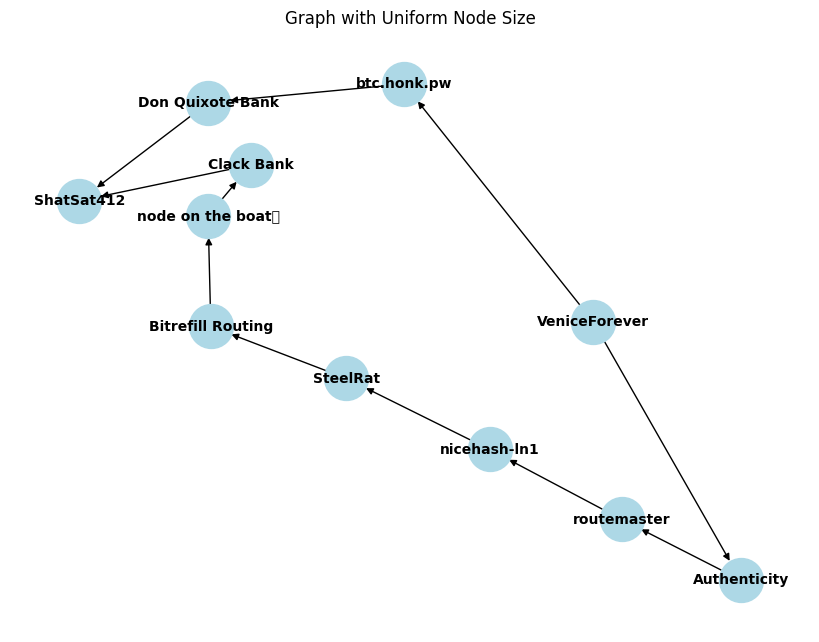

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# edges list construction
edges_df = final[["source-alias", "destination-alias"]]

G = nx.from_pandas_edgelist(edges_df, "source-alias", "destination-alias", create_using=nx.DiGraph())

#plt.figure(figsize=(8, 6))
#pos = nx.spring_layout(G)
#nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_color='black', font_weight='bold', arrows=True)
#plt.title("Graph from DataFrame of Edges")
#plt.show()


plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G) 
#pos = nx.circular_layout(G)
#pos = nx.planar_layout(G)
#pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=10, font_color='black', font_weight='bold', arrows=True)
plt.title("Graph with Uniform Node Size")
plt.show()

In [24]:
for i in nx.strongly_connected_components(G):
    print(i)

{'ShatSat412'}
{'Clack Bank'}
{'node on the boat⛵'}
{'Don Quixote Bank'}
{'btc.honk.pw'}
{'Bitrefill Routing'}
{'SteelRat'}
{'nicehash-ln1'}
{'routemaster'}
{'Authenticity'}
{'VeniceForever'}


In [25]:
final["amount"] = final["amount"].astype(float)
final["rate_fee"] = final["rate_fee"].astype(float)
final["base_fee"] = final["base_fee"].astype(float)
total_transaction_cost = sum(final["amount"] * final["rate_fee"] + final["base_fee"])
perc_cost = (total_transaction_cost * 100) / transaction_amount
print(f"Transacting {transaction_amount} sats costs {total_transaction_cost} ({perc_cost}% of transaction amount)")
print("Solver Status: ", results.solver[0]["System time"])

Transacting 1000000 sats costs 75713.36806759292 (7.571336806759292% of transaction amount)
Solver Status:  70.17


In [26]:
#from collections import Counter
#results = [tuple(i) for i in DF_channels_pos[["source-alias", "destination-alias"]].to_numpy()]
#unwrap = [e for i in results for e in i]
#extremes = [j for j in unwrap if Counter(unwrap)[j] == 1]
#def return_source(l: list):
#    if l[0] in [i for i, j in results]:
#        return l[0]
#    else: 
#        return l[1]
#sequence = []        
#source = return_source(extremes)
#sequence.append(source)
#while len(sequence) <= len(results):
#    for i,j in results:
#        if i == sequence[-1]:
#            sequence.append(j)
#for i in sequence:
#    print("⬇️", i)